# Загрузка данных (CIFAR-10), аугментации, визуализация батча.

- Базовая CNN-модель, функция потерь (CrossEntropy), оптимизатор (SGD+momentum).

- Тренировка и валидация, метрики (accuracy, confusion matrix).

- Визуализация внутренних активаций слоёв и Grad-CAM для интерпретации.

- Извлечение эмбеддингов и проекция UMAP (2D) для анализа разделимости классов.

- Небольшой демо-ретривал (поиск похожих изображений) на эмбеддингах.

- Блок SPP и мини-блок Inception — чтобы увидеть, как интегрируются архитектурные идеи.

В этом ноутбуке мы на практике пройдём базовый цикл работы с нейросетями для изображений на PyTorch:

In [1]:
# Базовая установка/импорты/сид для воспроизводимости
#!pip -q install umap-learn --upgrade

import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# Сид и устройство
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

# Данные: CIFAR-10 и аугментации

CIFAR-10: 10 классов, цветные изображения 32×32.

Для train применим лёгкие аугментации (RandomCrop, RandomHorizontalFlip), для test — только нормализация.

Сразу визуализируем несколько изображений, чтобы убедиться в корректности загрузки.

In [2]:
# Трансформации для train/test
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Датасеты и лоадеры
DATA_DIR = "/mnt/d/datasets" # например путь к папке с данными на диске D

train_ds = datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=train_tfms)
test_ds  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

classes = train_ds.classes
classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Быстрый просмотр батча

Сделаем обратную нормализацию и отрисуем сетку примеров с подписями классов. Это помогает поймать ошибки препроцессинга/аугментаций на старте.

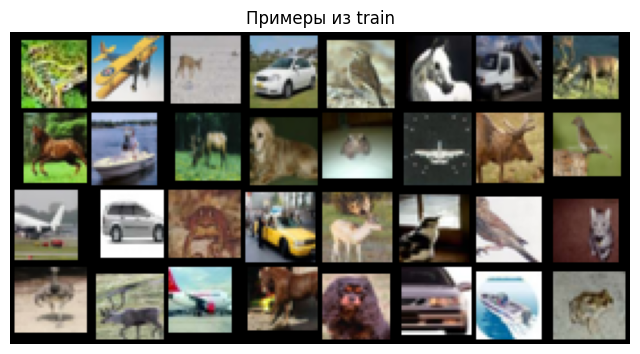

Метки первых 32: ['frog', 'airplane', 'deer', 'automobile', 'bird', 'horse', 'truck', 'deer', 'horse', 'ship', 'deer', 'dog', 'frog', 'airplane', 'deer', 'bird', 'airplane', 'automobile', 'frog', 'automobile', 'deer', 'cat', 'bird', 'cat', 'bird', 'deer', 'airplane', 'horse', 'dog', 'automobile', 'ship', 'frog']


In [3]:
# Вспомогательная функция: обратная нормализация для отображения
inv_mean = torch.tensor(mean).view(3,1,1)
inv_std  = torch.tensor(std).view(3,1,1)

def denorm(x):
    # x: (B,3,H,W) в тензоре torch, нормированный
    return (x.cpu()*inv_std + inv_mean).clamp(0,1)

# Визуализация одного батча
xb, yb = next(iter(train_loader))
grid = utils.make_grid(denorm(xb[:32]), nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.title("Примеры из train")
plt.show()

print("Метки первых 32:", [classes[int(t)] for t in yb[:32]])


# Модель: простая CNN + Global Average Pooling (GAP)

Мы реализуем компактную CNN:

Блоки: Conv → BN → ReLU → MaxPool, дважды.

Затем Conv → BN → ReLU для углубления признаков.

GlobalAveragePooling (усреднение по пространству) вместо длинных FC-слоёв → линейный классификатор.

Почему так:

GAP уменьшает переобучение и даёт фиксированный вектор признаков.

Модель достаточно лёгкая, чтобы обучиться за считанные минуты.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, feat_dim=128):
        super().__init__()
        # Блок 1: 3->32
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32x32 -> 16x16
        )
        # Блок 2: 32->64
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16x16 -> 8x8
        )
        # Блок 3 (углубление): 64->128
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # Проекция в признак (через GAP) и классификатор
        self.head = nn.Linear(128, num_classes)
        
    def forward(self, x, return_embed=False):
        x = self.conv1(x)      # (B,32,16,16)
        x = self.conv2(x)      # (B,64, 8, 8)
        x = self.conv3(x)      # (B,128,8, 8)
        # Global Average Pooling: усредняем по HxW
        gap = torch.mean(x, dim=(2,3))  # (B,128)
        logits = self.head(gap)         # (B,10)
        if return_embed:
            return logits, gap          # вернуть и логиты, и эмбеддинг
        return logits

model = SimpleCNN().to(device)

# Подсчитаем число параметров
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"Trainable params: {total_params/1e6:.2f}M")


SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (head): Linear(in_features=128, out_features=10, bias=True)
)
Trainable params: 0.09M


In [5]:
from torchinfo import summary

summary(model=model)

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       18,496
│    └─BatchNorm2d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-9                       73,856
│    └─BatchNorm2d: 2-10                 256
│    └─ReLU: 2-11                        --
├─Linear: 1-4                            1,290
Total params: 94,986
Trainable params: 94,986
Non-trainable params: 0

# Функция потерь, оптимизатор и цикл обучения

Loss: CrossEntropyLoss (мультиклассовая классификация).

Оптимизатор: SGD с momentum и weight decay (классическая «рабочая лошадка»).

Scheduler: StepLR для плавного снижения LR.

Логируем loss/accuracy на train и val по эпохам.

In [6]:
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    losses, preds, gts = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        preds.append(logits.argmax(1).detach().cpu())
        gts.append(yb.detach().cpu())
    loss_mean = np.mean(losses)
    y_pred = torch.cat(preds).numpy()
    y_true = torch.cat(gts).numpy()
    acc = accuracy_score(y_true, y_pred)
    return loss_mean, acc

EPOCHS = 12  # для семинара держим компактно
hist = []
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = run_epoch(model, train_loader, train=True)
    val_loss,   val_acc   = run_epoch(model, test_loader,  train=False)
    scheduler.step()
    dt = time.time()-t0
    hist.append((ep, train_loss, train_acc, val_loss, val_acc))
    print(f"Epoch {ep:02d} | "
          f"train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.3f} | "
          f"{dt:.1f}s")


Epoch 01 | train: loss=1.5446, acc=0.432 | val: loss=1.5951, acc=0.449 | 6.9s
Epoch 02 | train: loss=1.2259, acc=0.560 | val: loss=1.2180, acc=0.559 | 4.7s
Epoch 03 | train: loss=1.1116, acc=0.602 | val: loss=1.1851, acc=0.577 | 6.7s
Epoch 04 | train: loss=1.0271, acc=0.636 | val: loss=1.2271, acc=0.564 | 4.7s
Epoch 05 | train: loss=0.9720, acc=0.656 | val: loss=1.0070, acc=0.647 | 4.4s
Epoch 06 | train: loss=0.9118, acc=0.678 | val: loss=1.2186, acc=0.593 | 4.5s
Epoch 07 | train: loss=0.8830, acc=0.693 | val: loss=1.8093, acc=0.475 | 5.3s
Epoch 08 | train: loss=0.8509, acc=0.706 | val: loss=0.8797, acc=0.690 | 4.8s
Epoch 09 | train: loss=0.8200, acc=0.713 | val: loss=1.0240, acc=0.648 | 5.4s
Epoch 10 | train: loss=0.7986, acc=0.723 | val: loss=0.9070, acc=0.685 | 5.9s
Epoch 11 | train: loss=0.7202, acc=0.753 | val: loss=0.8246, acc=0.710 | 5.6s
Epoch 12 | train: loss=0.7089, acc=0.755 | val: loss=0.7772, acc=0.730 | 4.8s


# Оценка: матрица ошибок и per-class accuracy

Построим confusion matrix и посмотрим точность по каждому классу. 
Это помогает обнаружить «слабые места» модели.

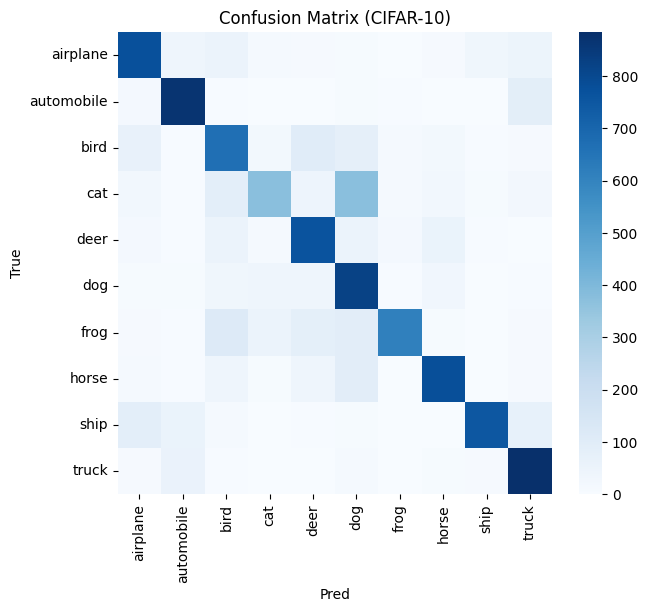

  airplane: 0.774
automobile: 0.868
      bird: 0.667
       cat: 0.376
      deer: 0.766
       dog: 0.822
      frog: 0.614
     horse: 0.778
      ship: 0.750
     truck: 0.884


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Сбор предсказаний на тесте
model.eval()
all_preds, all_gts = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(device))
        all_preds.append(logits.argmax(1).cpu())
        all_gts.append(yb)
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_gts).numpy()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix (CIFAR-10)")
plt.show()

# Per-class accuracy
per_class_acc = (cm.diagonal() / cm.sum(axis=1)).round(3)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls:>10}: {acc:.3f}")


# Визуализация активаций (feature maps)

Извлечём выходы промежуточных свёрточных слоёв через forward hooks и визуализируем несколько каналов. Это покажет, на какие паттерны «реагируют» ранние и средние слои.


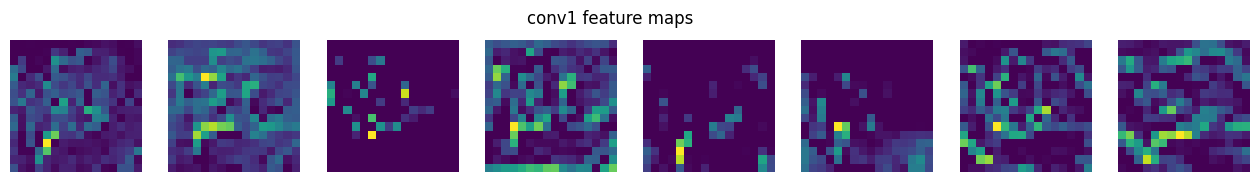

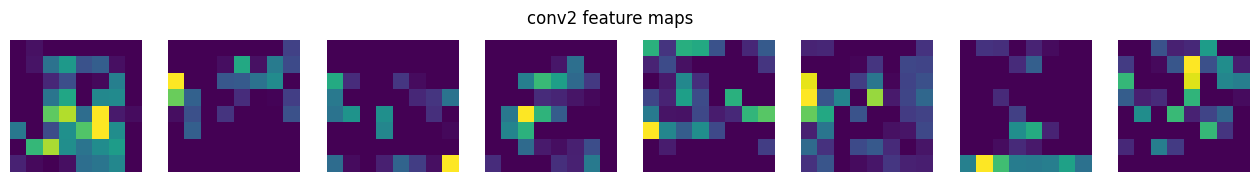

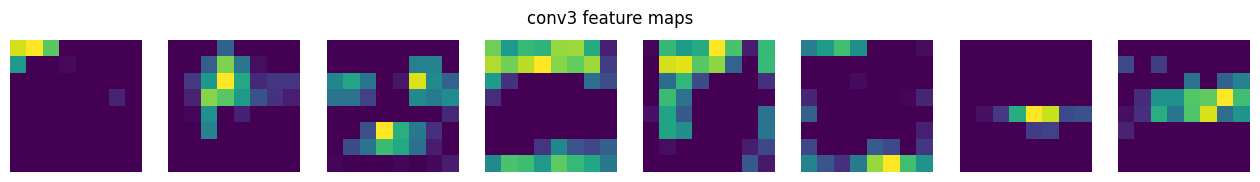

In [9]:
# Хук для сохранения активаций
activations = {}
def save_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()
    return hook

# Вешаем хуки на conv1, conv2, conv3
h1 = model.conv1.register_forward_hook(save_activation('conv1'))
h2 = model.conv2.register_forward_hook(save_activation('conv2'))
h3 = model.conv3.register_forward_hook(save_activation('conv3'))

# Прогоняем один батч
xb, yb = next(iter(test_loader))
_ = model(xb.to(device))

# Визуализируем несколько каналов для conv1/conv2/conv3
def show_feature_maps(act, n_maps=8, title=""):
    fm = act[0]  # берём первую картинку из батча: (C,H,W)
    C = fm.shape[0]
    n = min(n_maps, C)
    fig, axs = plt.subplots(1, n, figsize=(2*n, 2))
    for i in range(n):
        axs[i].imshow(fm[i].numpy(), cmap='viridis')
        axs[i].axis('off')
    fig.suptitle(title)
    plt.show()

show_feature_maps(activations['conv1'], title="conv1 feature maps")
show_feature_maps(activations['conv2'], title="conv2 feature maps")
show_feature_maps(activations['conv3'], title="conv3 feature maps")

# Чистим хуки (важно, чтобы не оставались висячие ссылки)
h1.remove(); h2.remove(); h3.remove();


# Grad-CAM: «куда смотрит» модель при классификации

Сделаем упрощённый Grad-CAM для последнего свёрточного блока:

1. Прямой проход → выбираем логит целевого класса.

2. Считаем градиенты по картам признаков последнего conv-слоя.

3. Усредняем градиенты по пространству → получаем веса каналов.

4. Взвешиваем каналы, суммируем → получаем теплокарту и накладываем на вход.

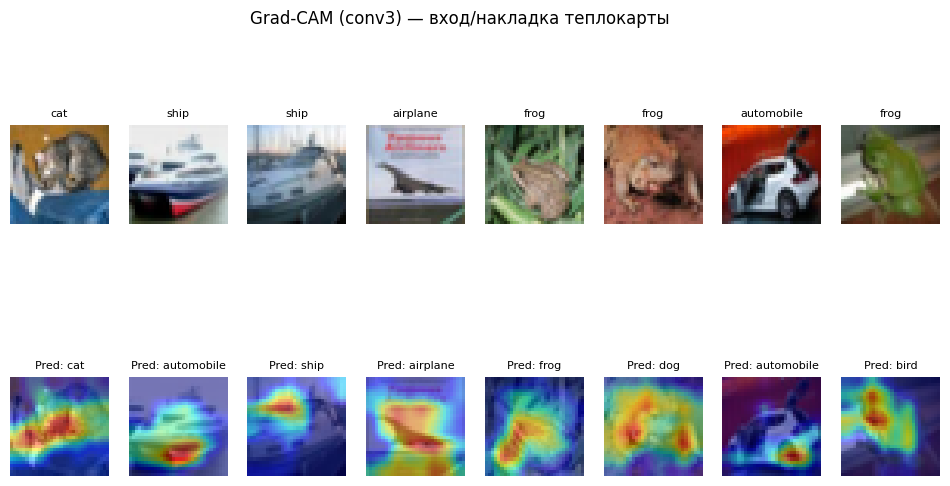

In [10]:
# Простой Grad-CAM для последнего conv-блока (conv3)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activ = None
        self.grads = None
        # хуки на форвард/бэквард
        self.fh = target_layer.register_forward_hook(self._save_activ)
        self.bh = target_layer.register_full_backward_hook(self._save_grads)

    def _save_activ(self, m, i, o): self.activ = o.detach()
    def _save_grads(self, m, gi, go): self.grads = go[0].detach()

    def __del__(self):
        # безопасно снимаем хуки при удалении
        try: self.fh.remove()
        except: pass
        try: self.bh.remove()
        except: pass

    def __call__(self, x, class_idx=None):
        # прямой проход
        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(1)
        # нулим градиенты и таргетим выбранный логит
        self.model.zero_grad(set_to_none=True)
        # суммируем таргетные логиты, чтобы вызвать backward
        selected = logits[torch.arange(x.size(0)), class_idx]
        selected.sum().backward(retain_graph=True)

        # средний градиент по HxW -> веса каналов
        weights = self.grads.mean(dim=(2,3), keepdim=True)  # (B,C,1,1)
        cam = (weights * self.activ).sum(dim=1, keepdim=True)  # (B,1,H,W)
        cam = F.relu(cam)
        # нормируем в [0,1]
        cam -= cam.amin(dim=(2,3), keepdim=True)
        cam /= (cam.amax(dim=(2,3), keepdim=True) + 1e-8)
        return cam, class_idx, logits.softmax(1)

# Инициализация Grad-CAM
gcam = GradCAM(model, model.conv3[0])  # берем сам Conv2d внутри conv3

# Возьмем несколько картинок из теста и визуализируем Grad-CAM
xb, yb = next(iter(test_loader))
xb_small = xb[:8].to(device)
cam, cls_idx, probs = gcam(xb_small)

# Ф-я отрисовки наложения
def overlay_cam(img_t, cam_t):
    # img_t: (3,H,W) нормированный; cam_t: (1,H',W') (совпадает с 8x8)
    # рескейлим cam до 32x32
    cam_up = F.interpolate(cam_t.unsqueeze(0), size=img_t.shape[1:], mode='bilinear', align_corners=False)[0,0]
    img = denorm(img_t.unsqueeze(0))[0]  # (3,H,W) в [0,1]
    # наложение через alpha
    heat = plt.cm.jet(cam_up.cpu().numpy())[:,:,:3]  # (H,W,3)
    base = np.transpose(img.numpy(), (1,2,0))
    out = (0.5*base + 0.5*heat).clip(0,1)
    return out

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(np.transpose(denorm(xb_small[i].unsqueeze(0))[0].numpy(), (1,2,0)))
    plt.axis('off'); plt.title(classes[int(yb[i])], fontsize=8)
    plt.subplot(2,8,8+i+1)
    ov = overlay_cam(xb_small[i].cpu(), cam[i].cpu())
    pred_lbl = classes[int(cls_idx[i])]
    plt.imshow(ov); plt.axis('off'); plt.title(f"Pred: {pred_lbl}", fontsize=8)
plt.suptitle("Grad-CAM (conv3) — вход/накладка теплокарты")
plt.show()


# Эмбеддинги и UMAP 2D

Возьмём эмбеддинг перед головой (вектор после GAP), построим UMAP-проекцию в 2D и раскрасим по классам.
Это наглядно показывает разделимость классов и «пограничные» зоны.

Embeddings: 100%|██████████| 40/40 [00:00<00:00, 48.26it/s]
/root/.venv/cv_course/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


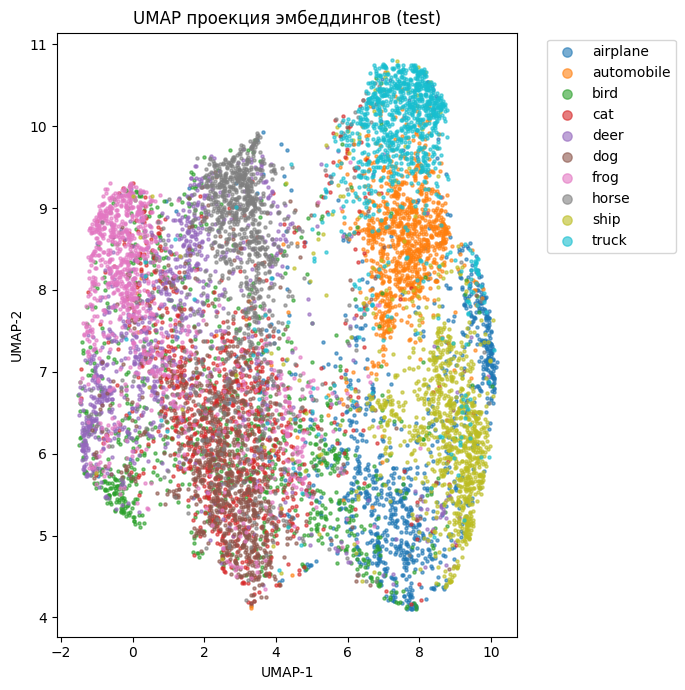

In [11]:
import umap
from tqdm import tqdm

# Соберём эмбеддинги со всего теста
model.eval()
embeds, labels = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Embeddings"):
        logits, em = model(xb.to(device), return_embed=True)
        embeds.append(em.cpu())
        labels.append(yb)
embeds = torch.cat(embeds).numpy()
labels = torch.cat(labels).numpy()

# UMAP 2D проекция
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=SEED)
z = reducer.fit_transform(embeds)  # (N,2)

# Отрисуем: по классам
plt.figure(figsize=(7,7))
for i, cls in enumerate(classes):
    idx = labels==i
    plt.scatter(z[idx,0], z[idx,1], s=5, label=cls, alpha=0.6)
plt.legend(markerscale=3, bbox_to_anchor=(1.05,1), loc='upper left')
plt.title("UMAP проекция эмбеддингов (test)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout(); plt.show()


# Мини-ретривал по эмбеддингам (поиск похожих изображений)

Построим простой индекс ближайших соседей (k-NN) на эмбеддингах теста и покажем топ-5 похожих к запросу.
Здесь нас интересует не «идеальная релевантность», а демонстрация идеи.

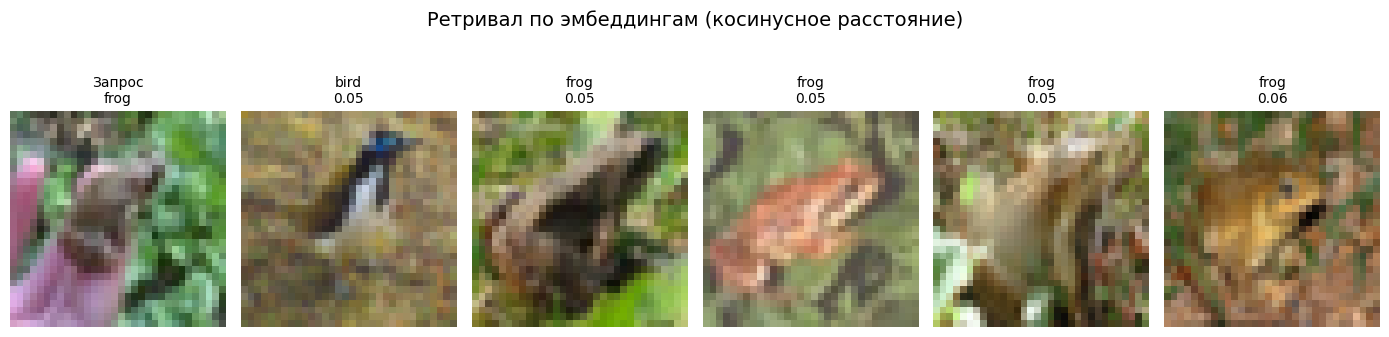

In [16]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import torch
import matplotlib.pyplot as plt

# Проверка нормализации эмбеддингов
def l2_normalize(embeds):
    """Нормализация векторов для корректного косинусного расстояния"""
    return embeds / np.linalg.norm(embeds, axis=1, keepdims=True)

# Подготовка данных
embeds_normalized = l2_normalize(embeds)  # Нормализуем все эмбеддинги
knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(embeds_normalized)

# Выбор случайного запроса
idx_q = np.random.randint(0, len(test_ds))
xq, yq = test_ds[idx_q]

# Убираем ToTensor() из transform, если xq уже тензор
if isinstance(xq, torch.Tensor):
    xq_t = xq.to(device)
else:
    xq_t = test_tfms(xq).to(device)  # Переносим тензор на устройство

# Получение эмбеддинга запроса
with torch.no_grad():
    _, e_q = model(xq_t.unsqueeze(0), return_embed=True)
e_q_normalized = l2_normalize(e_q.cpu().numpy())  # Нормализуем эмбеддинг запроса

# Поиск соседей
dist, ind = knn.kneighbors(e_q_normalized, n_neighbors=6, return_distance=True)
ind = ind[0]; dist = dist[0]

# Визуализация
plt.figure(figsize=(14, 4))
# Отображаем запрос
plt.subplot(1,6,1)
plt.imshow(np.transpose(denorm(xq_t.unsqueeze(0))[0].numpy(), (1,2,0)))
plt.axis('off'); plt.title(f"Запрос\n{classes[yq]}", fontsize=10)

# Отображаем соседей
for k in range(5):
    img, lbl = test_ds[ind[k+1]]  # Пропускаем самого себя (индекс 0)
    plt.subplot(1,6,2+k)
    plt.imshow(np.transpose(denorm(img.unsqueeze(0))[0].numpy(), (1,2,0)))
    plt.axis('off')
    plt.title(f"{classes[lbl]}\n{dist[k+1]:.2f}", fontsize=10)
plt.suptitle("Ретривал по эмбеддингам (косинусное расстояние)", fontsize=14)
plt.tight_layout()
plt.show()

# Сохранение артефактов эксперимента

Сохраним веса модели и основные метрики, чтобы потом можно было повторно загрузить и сравнить.

Сохранено: ./checkpoints/simplecnn_cifar10.pt


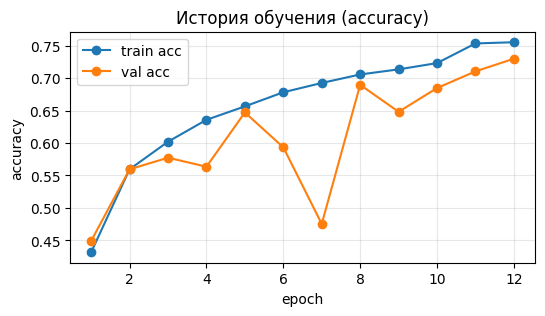

In [23]:
ckpt_dir = "./checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
torch.save({
    "model_state": model.state_dict(),
    "classes": classes,
    "history": hist,
    "seed": SEED,
}, os.path.join(ckpt_dir, "simplecnn_cifar10.pt"))
print("Сохранено:", os.path.join(ckpt_dir, "simplecnn_cifar10.pt"))

# Покажем историю обучения (accuracy)
ep, tr_l, tr_a, va_l, va_a = zip(*hist)
plt.figure(figsize=(6,3))
plt.plot(ep, tr_a, '-o', label='train acc')
plt.plot(ep, va_a, '-o', label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.grid(True, alpha=0.3)
plt.title("История обучения (accuracy)")
plt.show()


# Мини-блок Inception (пример сборки)

Идея: параллельные ветви с разными ядрами (1×1, 3×3, 5×5/факторизованные) и pooling-ветвь, затем конкатенация по каналам.
Здесь — компактный модуль для демонстрации формы тензоров.

In [2]:
class MiniInception(nn.Module):
    def __init__(self, in_ch, ch1x1=16, ch3x3=24, ch5x5=8, pool_proj=8):
        super().__init__()
        # 1x1
        self.b1 = nn.Sequential(
            nn.Conv2d(in_ch, ch1x1, kernel_size=1), nn.ReLU(inplace=True)
        )
        # 3x3
        self.b2 = nn.Sequential(
            nn.Conv2d(in_ch, ch3x3, kernel_size=3, padding=1), nn.ReLU(inplace=True)
        )
        # 5x5 (факторизуем в 3x3+3x3 для экономии FLOPs)
        self.b3 = nn.Sequential(
            nn.Conv2d(in_ch, ch5x5, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5, ch5x5, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        )
        # pool + 1x1
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_ch, pool_proj, kernel_size=1), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], dim=1)

# Демонстрация размеров
x = torch.randn(2, 32, 16, 16)
block = MiniInception(32, 16, 24, 8, 8)
y = block(x)
print("Input:", x.shape, "Output:", y.shape, "(channels sum = 16+24+8+8=56)")


Input: torch.Size([2, 32, 16, 16]) Output: torch.Size([2, 56, 16, 16]) (channels sum = 16+24+8+8=56)


In [7]:
from torchview import draw_graph
import PIL.Image as Image

device = torch.device("cpu")

# Убедитесь, что block - это корректный модуль PyTorch
graph = draw_graph(
    block,
    input_size=(1, 32, 16, 16),  # NCHW
    device=device,
    expand_nested=True,
    save_graph=True,
    filename="inception_block",
    graph_dir=".",
)


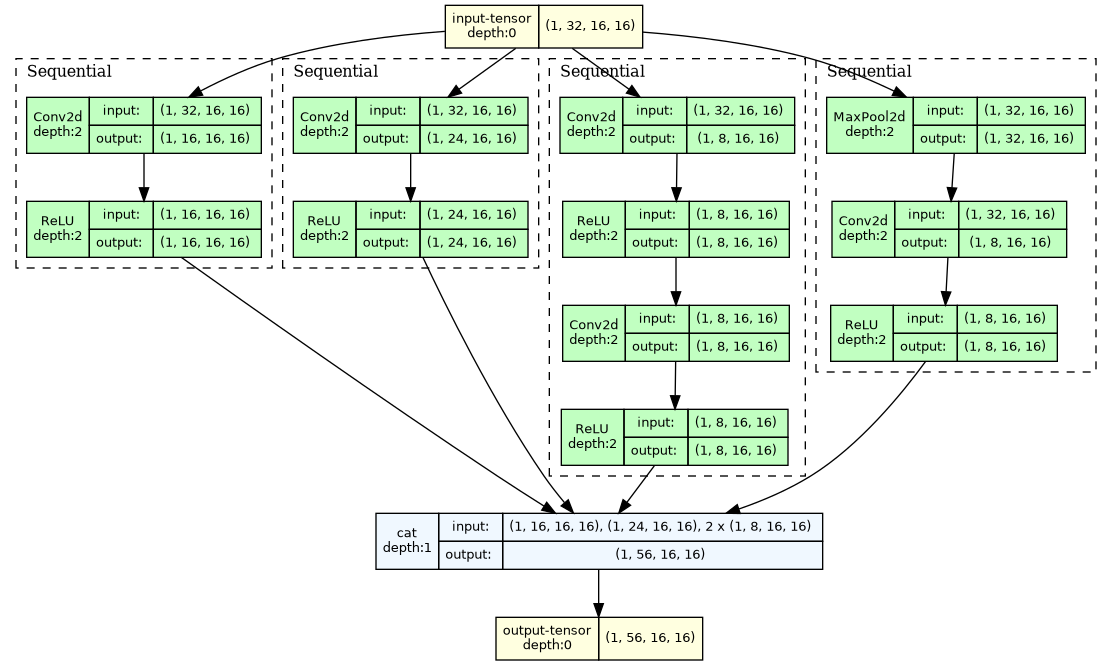

In [8]:
Image.open("/root/projects/study_projects/MUIV/cv_course/seminars/module03/inception_block.png")